<h1>Predicting movie ratings using IMDB metrics.</h1>

Dataset pulled from kaggle; <br />
https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset <br />
    <h6>thanks to Sarah N. from Learn Teach Code for help on this project</h6>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

In [2]:
mv = pd.read_csv(os.path.join('.', 'datasets', 'movie_metadata.csv'))

In [3]:
#Take a snapshot of the data to see what kind of dimensions we have
mv.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
#looks like there are some corrupted data so for simplicity let's just focus on the good ole' USA

In [5]:
mv_us = mv[mv.country=='USA']

In [6]:
#further disregard corrupted data and other outliers

In [7]:
mv_numeric = mv_us._get_numeric_data()
mv_numeric = mv_numeric.dropna()
mv_numer_pre = mv_numeric[(np.abs(stats.zscore(mv_numeric))<3).all(axis=1)]

In [8]:
km = KMeans(n_clusters = 8, random_state = 2)
km.fit(mv_numeric)
labels = km.labels_

In [9]:
#create a Principle Componenet Analysis on parsed data. To help visualize, we reduce dimensions
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(mv_numeric)
plt.scatter(plot_columns[:, 0], plot_columns[:,1], c = labels)

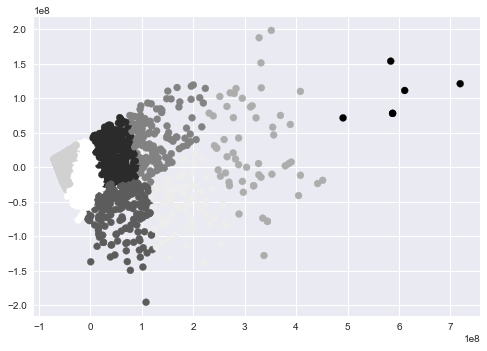

In [10]:
plt.show()

In [11]:
pca_2.explained_variance_ratio_

array([ 0.86789628,  0.13210151])

<h1>drawing correlations</h1>

In [12]:
mv_numeric.corr()["imdb_score"].sort_values()

title_year                  -0.144244
facenumber_in_poster        -0.067433
aspect_ratio                 0.037937
budget                       0.069896
actor_3_facebook_likes       0.088388
actor_1_facebook_likes       0.119000
actor_2_facebook_likes       0.128142
cast_total_facebook_likes    0.138960
director_facebook_likes      0.223412
gross                        0.269961
movie_facebook_likes         0.291469
num_user_for_reviews         0.349916
num_critic_for_reviews       0.358713
duration                     0.384089
num_voted_users              0.511762
imdb_score                   1.000000
Name: imdb_score, dtype: float64

In [13]:
column_set = (set(mv.columns) - set(mv_numeric.columns)) | set(['imdb_score'])
print column_set

set(['actor_3_name', 'genres', 'language', 'actor_1_name', 'color', 'country', 'content_rating', 'plot_keywords', 'director_name', 'movie_imdb_link', 'movie_title', 'imdb_score', 'actor_2_name'])


In [14]:
columns = mv_numeric.columns.tolist()
#filter columns
columns = [c for c in columns if c not in list(column_set)]

#define a targe
target = "imdb_score"

In [15]:
# split into Training and Testing data
train = mv_numeric.sample(frac=0.8, random_state = 1)
test = mv_numeric.loc[~mv_numeric.index.isin(train.index)]
print (train.shape)
print (test.shape)

(2404, 16)
(601, 16)


<h1>Linear Regression!</h1>

In [16]:
model = LinearRegression()
model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
#coefficients;
model.coef_

array([  2.90803661e-03,   1.19166989e-02,   4.42038665e-06,
         3.37872930e-05,   4.66606055e-05,   6.52373539e-10,
         3.20624397e-06,  -4.42107835e-05,  -2.81558094e-02,
        -5.70462555e-04,  -5.30680743e-09,  -1.97242521e-02,
         4.83949956e-05,  -1.11211117e-01,  -2.29687169e-06])

<h1>Make predictions and calculate error based on training data</h1>

In [18]:
predictions = model.predict(test[columns])
mean_squared_error(predictions, test[target])

0.66002840916631034

<h1>Try using Lasso model</h1>

In [19]:
reg = linear_model.Lasso(alpha = 0.1, max_iter = 10000, selection = 'random')
reg.fit(train[columns], train[target])

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False)

<h1>Make predictions and calculate error</h1>

In [20]:
predictions = reg.predict(test[columns])
mean_squared_error(predictions, test[target])

0.64540706097708056

<h3>Looks like we have a 64% chance to predict an IMDB score based off the given metrics</h3>